# Normalization comparisson
In this notebook, I compare the different methods of normalization.
As a simple metric, I use the enrichment score at 99%.
This analysis is done on the efficientnetB0 pretrained output: `level3.csv`


In [1]:
# import importlib
# importlib.reload(pycytominer)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycytominer import aggregate, annotate, normalize, feature_select, cyto_utils
from cytominer_eval import evaluate
from cytominer_eval.transform import metric_melt
from sklearn.decomposition import PCA
import sys
sys.path.insert(0, "/Users/mbornhol/git/neural-profiling")
from utils import data_selection as ds
from utils import eval

In [2]:
df = pd.read_csv('aggregated_efficientnet_median.csv', low_memory=False)

In [3]:
p = 0.995
meta = pd.read_csv('/Users/mbornhol/git/neural-profiling/pre-trained/data-prep/02_index_preperation/repurposing_info_external_moa_map_resolved.tsv', sep='\t')
meta = meta[['broad_sample', 'moa']]
meta.rename(columns = {'broad_sample' : 'Metadata_broad_sample', 'moa' : 'Metadata_moa'}, inplace=True)

In [4]:
def hist(df, features):
    melt = metric_melt(df.sample(200),
            features=features,
            metadata_features=meta_features)
    #bins = np.arange(-0.005, 0.005, 0.001)
    plt.style.use({'figure.facecolor':'white'})
    plt.hist(melt.similarity_metric)
def feats(df):
    features_ = []
    for col in df.columns.tolist():
        if col.startswith('efficientnet_'):
            features_.append(col)
    return features_

In [5]:
features = feats(df)
meta_features = []
for col in df.columns.tolist():
    if col.startswith('Metadata_'):
        meta_features.append(col)

In [6]:
# plot the similarity of the wells. Expected output from a pretrained net.
# hist(df,features)

In [7]:
def pca_plot(df):
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(df[features].values)
    df['pca-one'] = pca_result[:,0]
    df['pca-two'] = pca_result[:,1]
    df['pca-three'] = pca_result[:,2]
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    plt.style.use({'figure.facecolor':'white'})
    plt.scatter(df['pca-one'], df['pca-two'], s = 3, alpha= 0.4)
    plt.show()
# pca_plot(df)

## Without normalization

In [8]:
con = aggregate(
    df,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])

In [9]:
res = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res

,enrichment_percentile,threshold,ods_ratio,p-value
0,0.995,0.997685,1.94671,3.475692e-09


In [10]:
con = con[con["Metadata_broad_sample"] != "DMSO"]
pre_r = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="precision_recall",
        similarity_metric="pearson",
        precision_recall_k="R"
    )
pre_r

,Metadata_broad_sample,R,precision
0,BRD-A00218260-001-03-4,6.0,0.0
1,BRD-A00376169-001-01-6,1.0,0.0
2,BRD-A00546892-001-02-6,19.0,0.0
3,BRD-A00938334-001-01-3,2.0,0.0
4,BRD-A01636364-003-15-1,13.0,0.0
...,...,...,...
1138,BRD-K99504665-001-01-2,1.0,0.0
1139,BRD-K99545815-001-06-3,1.0,0.0
1140,BRD-K99604664-001-01-1,6.0,0.0
1141,BRD-K99749624-001-07-0,1.0,0.0


In [11]:
pre_r.mean()

R            8.731409
precision    0.041237
dtype: float64

## robustize

There doesn't seem to be a large difference between DMSO and all normalization.

In [12]:
rob_DMSO = normalize(
    profiles=df,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='robustize',
    output_file='none'
)
con = aggregate(
    rob_DMSO,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])
res_rob_DMSO = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_rob_DMSO

,enrichment_percentile,threshold,ods_ratio,p-value
0,0.995,0.90921,5.775086,6.949650e-109


In [13]:
con = con[con["Metadata_broad_sample"] != "DMSO"]
pre_r = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="precision_recall",
        similarity_metric="pearson",
        precision_recall_k="R"
    )
pre_r.mean()

R            8.731409
precision    0.049815
dtype: float64

In [14]:
rob_all = normalize(
    profiles=df,
    features=features,
    samples="all",
    method='robustize',
    output_file='none'
)
con = aggregate(
    rob_all,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])
res_rob_all = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_rob_all

,enrichment_percentile,threshold,ods_ratio,p-value
0,0.995,0.900471,5.141806,3.275326e-88


In [15]:
con = con[con["Metadata_broad_sample"] != "DMSO"]
pre_r = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="precision_recall",
        similarity_metric="pearson",
        precision_recall_k="R"
    )
pre_r.mean()

R            8.731409
precision    0.049649
dtype: float64

## standardize

In [16]:
stand_dmso = normalize(
    profiles=df,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='standardize',
    output_file='none'
)

In [17]:
con = aggregate(
    stand_dmso,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])
res_stand_dmso = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_stand_dmso

,enrichment_percentile,threshold,ods_ratio,p-value
0,0.995,0.896088,6.323592,1.183704e-127


In [18]:
con = con[con["Metadata_broad_sample"] != "DMSO"]
pre_r = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="precision_recall",
        similarity_metric="pearson",
        precision_recall_k="R"
    )
pre_r.mean()

R            8.731409
precision    0.049563
dtype: float64

## Mad robustize

In [19]:
mad_dmso = normalize(
    profiles=df,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='mad_robustize',
    output_file='none'
)
con = aggregate(
    mad_dmso,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])
res_mad_dmso = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_mad_dmso

,enrichment_percentile,threshold,ods_ratio,p-value
0,0.995,0.911304,5.548128,2.411293e-101


In [20]:
con = con[con["Metadata_broad_sample"] != "DMSO"]
pre_r = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="precision_recall",
        similarity_metric="pearson",
        precision_recall_k="R"
    )
pre_r.mean()

R            8.731409
precision    0.049737
dtype: float64

## spherize

In [21]:
sphere = normalize(
    profiles=df,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='spherize',
    output_file='none'
)
con = aggregate(
    sphere,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])
res_sphere = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_sphere

,enrichment_percentile,threshold,ods_ratio,p-value
0,0.995,0.37479,15.450705,0.0


In [22]:
con = con[con["Metadata_broad_sample"] != "DMSO"]
pre_r = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="precision_recall",
        similarity_metric="pearson",
        precision_recall_k="R"
    )
pre_r.mean()

R            8.731409
precision    0.072201
dtype: float64

## mad_rob and then spherize

In [23]:
normed = normalize(
    profiles=df,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='mad_robustize',
    output_file='none'
)

sphere = normalize(
    profiles=normed,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='spherize',
    output_file='none'
)
con = aggregate(
    sphere,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])
res_sphere = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_sphere

,enrichment_percentile,threshold,ods_ratio,p-value
0,0.995,0.37479,15.450705,0.0


In [24]:
con = con[con["Metadata_broad_sample"] != "DMSO"]
pre_r = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="precision_recall",
        similarity_metric="pearson",
        precision_recall_k="R"
    )
pre_r.mean()

R            8.731409
precision    0.072201
dtype: float64

In [25]:
# standardize and then spherize
sphere = normalize(
    profiles=stand_dmso,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='spherize',
    output_file='none'
)
con = aggregate(
    sphere,
    strata=["Metadata_broad_sample"],
    features=features
)

con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])
res_stand_sphere = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_stand_sphere

,enrichment_percentile,threshold,ods_ratio,p-value
0,0.995,0.37479,15.450705,0.0


In [26]:
con = con[con["Metadata_broad_sample"] != "DMSO"]
pre_r = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="precision_recall",
        similarity_metric="pearson",
        precision_recall_k="R"
    )
pre_r.mean()

R            8.731409
precision    0.072201
dtype: float64

## Plot PCA

Explained variation per principal component: [0.50562739 0.10818844 0.06836398]
Explained variation per principal component: [0.43458172 0.13342128 0.0787094 ]
Explained variation per principal component: [0.51577579 0.08585414 0.06115663]
Explained variation per principal component: [0.50952242 0.10840054 0.06856008]


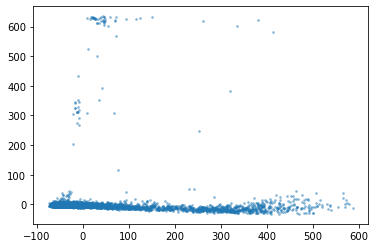

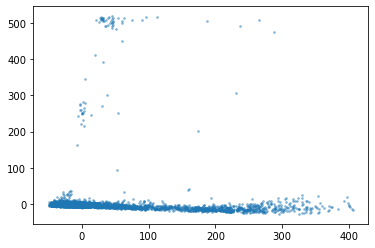

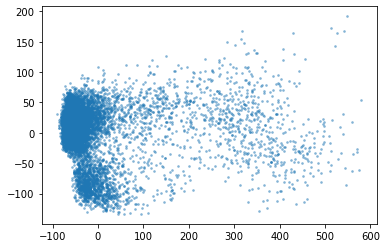

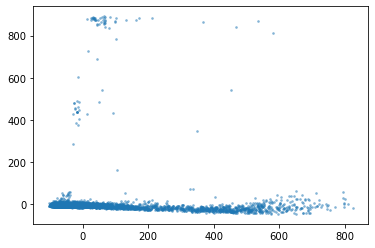

In [27]:
pca_plot(rob_DMSO)
pca_plot(rob_all)
pca_plot(stand_dmso)
pca_plot(mad_dmso)

Explained variation per principal component: [0.18571787 0.12333439 0.05559476]
Explained variation per principal component: [0.18571787 0.12333439 0.05559476]


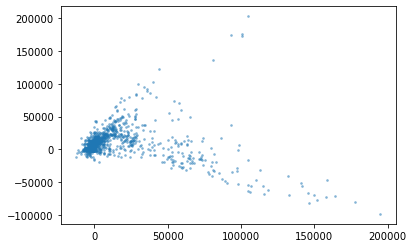

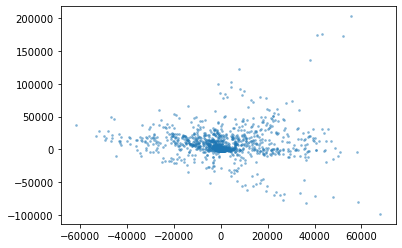

In [28]:
pca_plot(sphere)
pca = PCA(n_components=3)
pca_result = pca.fit_transform(sphere[features].values)
sphere['pca-one'] = pca_result[:,0]
sphere['pca-two'] = pca_result[:,1]
sphere['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
plt.style.use({'figure.facecolor':'white'})
plt.scatter(sphere['pca-three'], sphere['pca-two'], s = 3, alpha= 0.4)
plt.show()

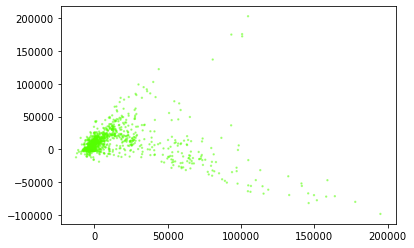

In [29]:
def is_dmso(sample):
    if sample == 'DMSO':
        return 0
    else:
        return 1
sphere['color'] = sphere.Metadata_broad_sample.apply(is_dmso)
plt.style.use({'figure.facecolor':'white'})
plt.scatter(sphere['pca-one'], sphere['pca-two'], c = sphere['color'], marker= 'o', s = 2, alpha= 0.4, cmap = 'prism')
plt.show()

## Feature selection

In [30]:
normed = normalize(
    profiles=df,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='mad_robustize',
    output_file='none'
)

feature_select_ops = [
    "variance_threshold",
    'drop_na_columns',
    "drop_outliers",
]
select_var = feature_select(
    profiles=normed,
    features=features,
    operation=feature_select_ops,
    freq_cut=0.01,
    unique_cut=0.1,
)
print(select_var.shape)
print(normed.shape)

(8733, 4023)
(8733, 6417)


In [31]:
con = aggregate(
    select_var,
    strata=["Metadata_broad_sample"],
    features=feats(select_var)
)
con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])

res_select_other = evaluate(
        profiles=con,
        features=feats(con),
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_select_other

,enrichment_percentile,threshold,ods_ratio,p-value
0,0.995,0.925502,5.911827,1.720081e-113


In [33]:
con = con[con["Metadata_broad_sample"] != "DMSO"]
pre_r = evaluate(
        profiles=con,
        features=feats(con),
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="precision_recall",
        similarity_metric="pearson",
        precision_recall_k="R"
    )
pre_r.mean()

R            8.731409
precision    0.047361
dtype: float64

## Feature selection with Spherized

In [34]:
sphere = normalize(
    profiles=select_var,
    features=feats(select_var),
    samples="Metadata_broad_sample == 'DMSO'",
    method='spherize',
    output_file='none'
)

con = aggregate(
    sphere,
    strata=["Metadata_broad_sample"],
    features=feats(select_var)
)
con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])

res_select_other = evaluate(
        profiles=con,
        features=feats(con),
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_select_other

,enrichment_percentile,threshold,ods_ratio,p-value
0,0.995,0.361529,16.179841,0.0


In [35]:
con = con[con["Metadata_broad_sample"] != "DMSO"]
pre_r = evaluate(
        profiles=con,
        features=feats(con),
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="precision_recall",
        similarity_metric="pearson",
        precision_recall_k="R"
    )
pre_r.mean()

# Check these results for P@R

R            8.731409
precision    0.073687
dtype: float64

In [ ]:
import sys
sys.path.insert(0, "/Users/mbornhol/git/neural-profiling")
from utils import eval

e = eval.evaluation(con)
mad_pre_r = e.eval(df, operation = 'precision_recall', eval_range='R').precision.mean()

In [ ]:
normed = normalize(
    profiles=df,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='mad_robustize',
    output_file='none'
)

sphere = normalize(
    profiles=normed,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='spherize',
    output_file='none'
)
con = aggregate(
    sphere,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta, how='left', on=['Metadata_broad_sample'])

e = eval.evaluation(con)
sph_pre_r = e.eval(df, operation = 'precision_recall', eval_range='R').precision.mean()

In [ ]:
sph_pre_r

In [ ]:
mad_pre_r
